--- SparkSession Created and Data Loaded ---
--- Data Aggregated by Route ---
--- Feature Engineering for Clustering Complete ---

--- Calculating BIC for GMM (K=2 to K=10) ---
BIC for K=2: 65.35
BIC for K=3: 85.38
BIC for K=4: -68.16
BIC for K=5: -151.97
BIC for K=6: -398.58
BIC for K=7: -210.09
BIC for K=8: 65.30
BIC for K=9: -505.46
BIC for K=10: 190.61

--- BIC Calculation Complete ---


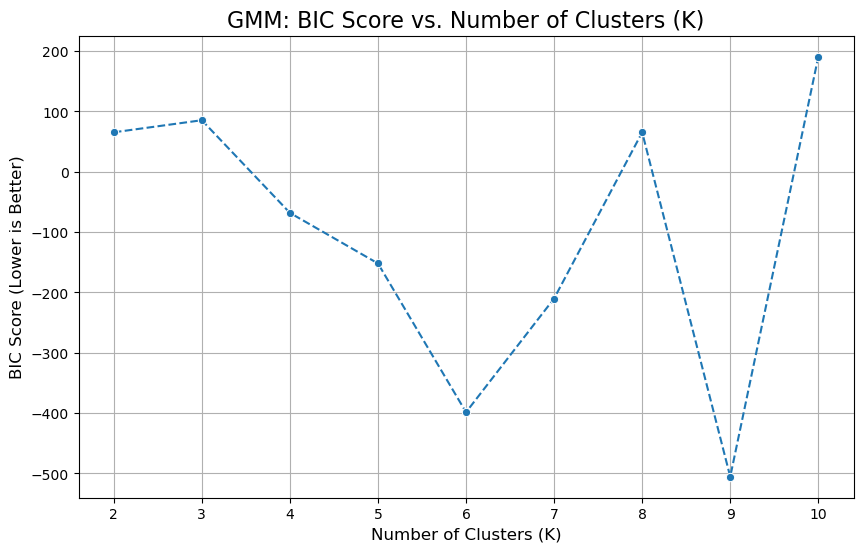


--- Optimal K based on lowest BIC: 9 ---


In [2]:
# ===================================================================
# === SCRIPT: GAUSSIAN MIXTURE MODEL (GMM) CLUSTERING =============
# ===================================================================

# === Imports ===
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg, first, concat_ws
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.clustering import GaussianMixture # Import GMM
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Setup Spark and Load Data ===
spark = SparkSession.builder.appName("FlightPulse-GMM-Clustering").getOrCreate()
df = spark.read.csv("flights.csv", header=True, inferSchema=True)
print("--- SparkSession Created and Data Loaded ---")

# === Step 2: Feature Engineering & Aggregation (Same as K-Means prep) ===
df_with_features = df.withColumn(
    "route", concat_ws("-", col("DEPARTURE_STATION_CD"), col("ARRIVAL_STATION_CD"))
).withColumn(
    "TotalSeats", col("FIRST_CLASS_SEATS") + col("BUSINESS_CLASS_SEATS") + col("ECONOMY_SEATS")
).withColumn(
    "TotalPax", col("TIER1_ELIGIBLE_PAX") + col("TIER2_ELIGIBLE_PAX") + col("TIER3_ELIGIBLE_PAX")
)

route_dna = df_with_features.groupBy("route").agg(
    count("*").alias("FlightFrequency"),
    first("HAUL").alias("HaulType"),
    avg("TotalSeats").alias("AvgTotalSeats"),
    (avg(col("FIRST_CLASS_SEATS") + col("BUSINESS_CLASS_SEATS")) / (avg("TotalSeats") + 1e-6)).alias("PremiumSeatRatio"),
    (avg(col("TIER1_ELIGIBLE_PAX")) / (avg("TotalPax") + 1e-6)).alias("Tier1PassengerRatio")
)
print("--- Data Aggregated by Route ---")

# === Step 3: Prepare Data for GMM (Scaling is crucial) ===
categorical_cols = ["HaulType"]
numerical_cols = ["FlightFrequency", "AvgTotalSeats", "PremiumSeatRatio", "Tier1PassengerRatio"]

indexer = StringIndexer(inputCol="HaulType", outputCol="HaulType_index")
assembler = VectorAssembler(inputCols=["HaulType_index"] + numerical_cols, outputCol="features_unscaled")
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features")

pipeline = Pipeline(stages=[indexer, assembler, scaler])
route_ml_ready = pipeline.fit(route_dna).transform(route_dna)
print("--- Feature Engineering for Clustering Complete ---")



# === Step 4: Find Optimal K using BIC for GMM ===
import numpy as np # Make sure numpy is imported

bic_scores = []
k_values = range(2, 11)
num_features = len(route_ml_ready.select("features").first()[0]) # Get number of features (d)

print("\n--- Calculating BIC for GMM (K=2 to K=10) ---")
for k in k_values:
    gmm = GaussianMixture(featuresCol='features', k=k, seed=1)
    model = gmm.fit(route_ml_ready)

    # Get the log-likelihood
    summary = model.summary
    log_likelihood = summary.logLikelihood
    num_samples = route_ml_ready.count() # Number of data points (routes)

    # Calculate the number of parameters (p) for GMM
    # p = k * (d + d*(d+1)/2 + 1) - 1
    # d = num_features
    # We calculate d*(d+1)/2 for the covariance matrix parameters
    num_params = k * (num_features + num_features * (num_features + 1) / 2 + 1) - 1

    # BIC formula: -2 * logLikelihood + num_params * log(num_samples)
    bic = -2 * log_likelihood + num_params * np.log(num_samples)
    bic_scores.append(bic)
    print(f"BIC for K={k}: {bic:.2f}")

print("\n--- BIC Calculation Complete ---")

# === Step 5: Plot BIC Scores ===
plt.figure(figsize=(10, 6))
sns.lineplot(x=list(k_values), y=bic_scores, marker='o', linestyle='--')
plt.title('GMM: BIC Score vs. Number of Clusters (K)', fontsize=16)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('BIC Score (Lower is Better)', fontsize=12)
plt.xticks(list(k_values))
plt.grid(True)
plt.show()

# Find the K with the lowest BIC score
optimal_k_bic = k_values[np.argmin(bic_scores)]
print(f"\n--- Optimal K based on lowest BIC: {optimal_k_bic} ---")